# t-SNE




In [6]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import time

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

#### **t-SNE**
Low-dimensional Distribution: t-Distribution
The key innovation in t-SNE introduced by van der Maaten and Hinton (2008) lies in the choice of the low-dimensional similarity distribution, which uses a t-Distribution instead of a Gaussian distribution.

---

#### **Use Cases**
t-SNE is a popular tool for exploring and visualizing high-dimensional data by reducing it to two or three dimensions. Its strength lies in capturing local structures, making it especially useful for:
- **Visualization of Complex Data**: t-SNE helps in understanding patterns within datasets like MNIST (handwritten digits) or image datasets. By mapping the data into lower dimension, it provides intuitive insights into relationships between different classes or clusters.
- **Cluster Analysis**: It excels at revealing clustering structures, making it a great choice for identifying similar groups in data.

---

#### **Limitations**
- **Computational Cost**: The algorithm has a complexity of \(O(N^2)\), meaning it will take more time for large datasets.
- **Loss of Global Structure**: t-SNE prioritizes preserving local neighborhoods, often at the expense of global relationships. This can distort the visualization of distant clusters.
- **Hyperparameter Sensitivity**: The results depend heavily on parameters like **perplexity** and **learning rate**.

---

#### **Algorithm Description**
##### 1. **High-Dimensional Similarities**
   - Pairwise similarities between points in the high-dimensional space are computed using a Gaussian distribution and Euclidean distances. For each point, the variance (\(\sigma\)) is chosen dynamically using a grid search to achieve the desired perplexity.

##### 2. **Symmetric Normalization**
   - A symmetric version of the pairwise affinities matrix is computed to ensure consistency and numerical stability. This is essential for accurate optimization.

##### 3. **Low-Dimensional Similarities**
   - Pairwise similarities between points in the low-dimensional space are calculated using a **Student-t distribution** with one degree of freedom. This distribution is robust to long-tailed data and helps separate clusters more effectively.

##### 4. **Optimization via KL Divergence**
   - The algorithm minimizes the **Kullback-Leibler (KL) divergence** between the high-dimensional and low-dimensional probability distributions using gradient descent. This step ensures that local structures in the high-dimensional space are preserved.

##### 5. **Early Exaggeration**
   - During the first few iterations (e.g., 350 iterations), the algorithm exaggerates the pairwise affinities in the high-dimensional space by multiplying them by a factor (e.g., 4.0). This helps separate clusters in the low-dimensional space early in the optimization process.

##### 6. **Dynamic Learning Rate and Momentum**
   - The learning rate starts high (e.g., 200) and decreases after a specified number of iterations (e.g., 800) to allow fine-tuning of the embeddings. Momentum is also adjusted dynamically to improve convergence and avoid local minima.

---

#### **Key Hyperparameters**
1. **Perplexity**:
   - Balances between local and global structures by adjusting the effective number of neighbors for each point.
2. **Learning Rate**:
   - Controls the magnitude of updates during gradient descent. Fine-tuning this parameter is essential for avoiding divergence or slow convergence.
3. **Early Exaggeration**:
   - Strengthens local relationships during the early optimization stage to improve cluster separation.
4. **Number of Iterations**:
   - Determines the total optimization steps. Higher values often lead to better convergence but increase computational cost.

---

#### **Practical Considerations**
1. **Vectorized Implementation**:
   - The algorithm's computations, including pairwise distances and gradients, are vectorized for efficiency, reducing reliance on nested loops.
  
---


### **References**
- van der Maaten, L., & Hinton, G. (2008). Visualizing Data using t-SNE. *Journal of Machine Learning Research, 9*, 2579-2605.  
  [Full Paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

- The implementation of this algorithm was inspired by the detailed explanation and walkthrough provided in the following article:  
  [t-SNE from Scratch with Numpy](https://towardsdatascience.com/t-sne-from-scratch-ft-numpy-172ee2a61df7)
---


# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [7]:
import numpy as np

class CustomTSNE:
    def __init__(self, perplexity=50.0, n_components=2, n_iter=1000, learning_rate=200.0, early_exaggeration=4.0):
        """
        Initialize the t-SNE algorithm with given hyperparameters.
        """
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.early_exaggeration = early_exaggeration

    def fit_transform(self, X):
        """
        Compute the low-dimensional embeddings for the input data.
        """
        p_ij = self._compute_pairwise_affinities(X)
        p_ij_symmetric = self._compute_symmetric_affinities(p_ij)
        Y = self._initialize_embedding(X)
        Y = self._optimize_embedding(p_ij_symmetric, Y)
        return Y

    def transform(self, X_train, Y_fitted, X_new):
        """
        Map new data points into the precomputed t-SNE map.
        """
        n_train = X_train.shape[0]
        n_new = X_new.shape[0]
        Y_new = np.zeros((n_new, self.n_components))

        for i in range(n_new):
            diff = X_new[i] - X_train
            norm = np.linalg.norm(diff, axis=1)
            p_i = np.exp(-norm**2 / (2 * self._grid_search(diff, i)**2))
            p_i /= np.sum(p_i)
            Y_new[i] = np.sum(p_i[:, None] * Y_fitted, axis=0)

        return Y_new

    def _compute_pairwise_affinities(self, X):
        """
        Compute pairwise affinities in the high-dimensional space using Gaussian distribution.
        """
        n = len(X)
        diff = X[:, None, :] - X[None, :, :]
        norm_squared = np.sum(diff**2, axis=2)
        σ = np.array([self._grid_search(diff[i], i) for i in range(n)])
        σ_matrix = σ[:, None]
        p_ij = np.exp(-norm_squared / (2 * σ_matrix**2))
        np.fill_diagonal(p_ij, 0)
        p_ij = p_ij / np.sum(p_ij, axis=1, keepdims=True)
        p_ij = np.nan_to_num(p_ij, nan=0, posinf=0, neginf=0)
        return p_ij

    def _grid_search(self, diff, i):
        """
        Perform grid search to find the optimal variance (σ) for the given perplexity.
        """
        target_entropy = np.log(self.perplexity)
        norm = np.linalg.norm(diff, axis=1)
        std_norm = np.std(norm)
        best_σ = 1.0
        min_error = np.inf
        for σ in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
            p = np.exp(-norm**2 / (2 * σ**2))
            p[i] = 0
            if np.sum(p) == 0:
                continue
            p /= np.sum(p)
            p = np.maximum(p, np.nextafter(0, 1))
            entropy = -np.sum(p * np.log2(p))
            error = np.abs(entropy - target_entropy)
            if error < min_error:
                min_error = error
                best_σ = σ
        return best_σ

    def _compute_symmetric_affinities(self, p_ij):
        """
        Compute the symmetric affinities matrix for optimization.
        """
        n = len(p_ij)
        return (p_ij + p_ij.T) / (2 * n)

    def _initialize_embedding(self, X):
        """
        Initialize the low-dimensional embeddings randomly.
        """
        n = len(X)
        return np.random.normal(0, 1e-4, (n, self.n_components))

    def _optimize_embedding(self, p_ij_symmetric, Y):
        """
        Optimize the low-dimensional embeddings using gradient descent.
        """
        T = self.n_iter  
        momentum = 0.5  
        Y_prev = np.zeros_like(Y)  
    
        for t in range(T):
            exaggeration = self.early_exaggeration if t < 350 else 1.0
            current_lr = self.learning_rate if t < 800 else self.learning_rate * 0.3
            q_ij = self._compute_low_dimensional_affinities(Y)
            gradient = self._compute_gradient(exaggeration * p_ij_symmetric, q_ij, Y)
            Y_update = -current_lr * gradient + momentum * (Y - Y_prev)
            Y_prev = Y.copy()
            Y += Y_update
            if t == 350:
                momentum = 0.8
            kl = np.sum(p_ij_symmetric * np.log(np.maximum(p_ij_symmetric / q_ij, np.nextafter(0, 1))))
            loss = np.sum(np.abs(p_ij_symmetric - q_ij))
            if t % 50 == 0 or t == T - 1:
                print(f"Iteration {t}: KL divergence = {kl:.4f}")
        return Y

    def _compute_low_dimensional_affinities(self, Y):
        """
        Compute pairwise affinities in the low-dimensional space using t-distribution.
        """
        n = len(Y)
        diff = Y[:, None, :] - Y[None, :, :]
        norm_squared = np.sum(diff**2, axis=2) 
        q_ij = (1 + norm_squared) ** -1
        np.fill_diagonal(q_ij, 0) 
        q_ij /= np.sum(q_ij) 
        q_ij = np.maximum(q_ij, np.nextafter(0, 1))
        return q_ij

    def _compute_gradient(self, p_ij, q_ij, Y):
        """
        Compute the gradient of the cost function for optimization.
        """
        n = len(Y)
        diff = Y[:, None, :] - Y[None, :, :]  
        norm_squared = np.sum(diff**2, axis=2)  
        factor = (p_ij - q_ij) / (1 + norm_squared)
        factor = factor[:, :, None]  
        gradient = 4 * np.sum(factor * diff, axis=1)
        return gradient


# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

### **Dataset Choice and Suitability for t-SNE**

#### **Why Did We Choose the Digits Dataset?**
The Digits dataset from sklearn is perfect for t-SNE because it has 1,797 examples of handwritten digits (0-9), each represented as a 64-dimensional feature vector (8x8 pixels). t-SNE is great at reducing high-dimensional data to 2D or 3D while keeping similar points close together.

#### **Why is t-SNE a Good Fit?**
**Revealing Clusters**: 
   - Since the data has labels (digits 0-9), we can see how well t-SNE groups similar digits into clusters.

#### **Data Preparation**
Here’s what we did to prepare the data:
1. **Normalize the Features**:
   - We scaled the data to values between 0 and 1 using `MinMaxScaler`. This prevents any feature with a larger range from dominating the distance calculations.
2. **Train-Test Split**:
   - We split the data into 80% for training and 20% for testing using `train_test_split`. This lets us check how well t-SNE can map new points into the existing low-dimensional space.



In [8]:
# Load and prepare the dataset
data = load_digits()

# Extract features and labels
X = data.data
y = data.target

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

Iteration 0: KL divergence = 3.7170
Iteration 50: KL divergence = 2.1089
Iteration 100: KL divergence = 1.8905
Iteration 150: KL divergence = 1.8270
Iteration 200: KL divergence = 1.7969
Iteration 250: KL divergence = 1.7798
Iteration 300: KL divergence = 1.7689
Iteration 350: KL divergence = 1.7614
Iteration 400: KL divergence = 1.1353
Iteration 450: KL divergence = 1.0093
Iteration 500: KL divergence = 0.9427
Iteration 550: KL divergence = 0.8998
Iteration 600: KL divergence = 0.8690
Iteration 650: KL divergence = 0.8456
Iteration 700: KL divergence = 0.8271
Iteration 750: KL divergence = 0.8119
Iteration 800: KL divergence = 0.7991
Iteration 850: KL divergence = 0.7951
Iteration 900: KL divergence = 0.7919
Iteration 950: KL divergence = 0.7888
Iteration 999: KL divergence = 0.7859

Custom t-SNE runtime: 123.93 seconds
sklearn t-SNE runtime: 4.98 seconds


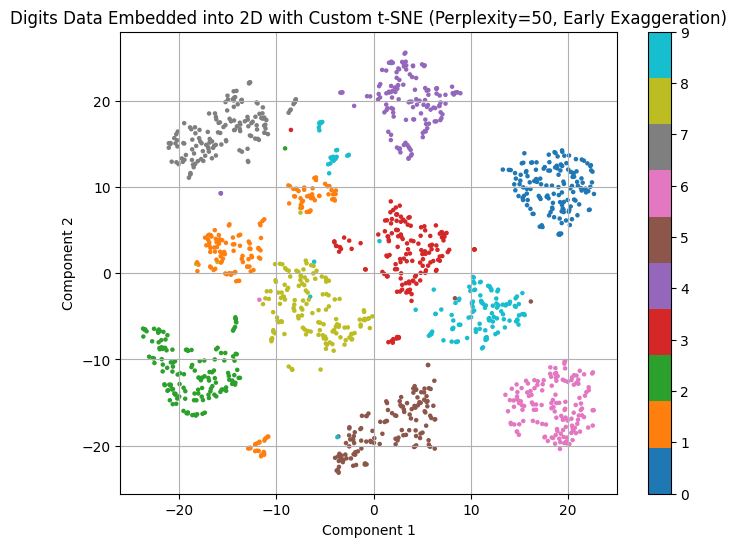

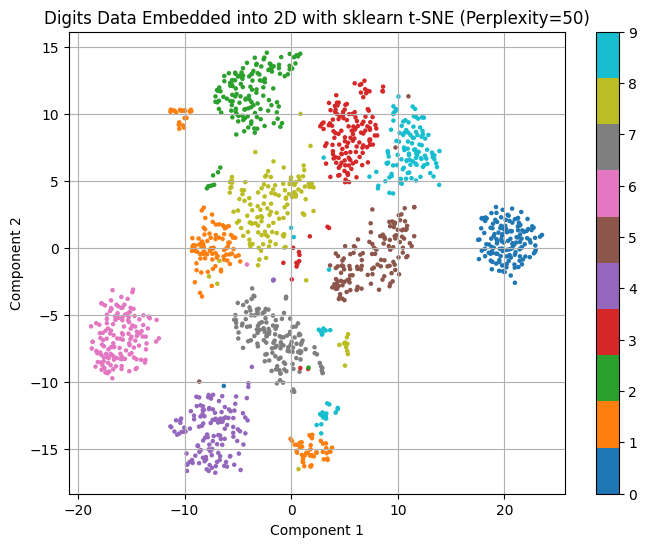

In [9]:

# Number of samples in training set
N = X_train.shape[0]

# Measure time for Custom t-SNE implementation
start_time_custom = time.time()
custom_tsne = CustomTSNE(n_components=2, perplexity=N/10, n_iter=1000, learning_rate=200, early_exaggeration=4.0)
custom_Y = custom_tsne.fit_transform(X_train)
end_time_custom = time.time()
custom_tsne_time = end_time_custom - start_time_custom

print()
print(f"Custom t-SNE runtime: {custom_tsne_time:.2f} seconds")

# Measure time for sklearn t-SNE implementation
start_time_sklearn = time.time()
sk_tsne = TSNE(n_components=2, init='random', perplexity=N/10, learning_rate=200, n_iter=1000, random_state=42)
sk_Y = sk_tsne.fit_transform(X_train)
end_time_sklearn = time.time()
sklearn_tsne_time = end_time_sklearn - start_time_sklearn
print(f"sklearn t-SNE runtime: {sklearn_tsne_time:.2f} seconds")

# Visualization of Custom t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('Digits Data Embedded into 2D with Custom t-SNE (Perplexity=50, Early Exaggeration)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# Visualization of sklearn t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('Digits Data Embedded into 2D with sklearn t-SNE (Perplexity=50)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


### **Comparison Between Custom and sklearn t-SNE Implementations**

#### **Visual Results**
Both implementations successfully create clusters that represent the digits (0-9). However, the **sklearn implementation** tends to produce tighter, more distinct clusters with clearer boundaries. On the other hand, the **custom implementation** achieves good clustering but shows slightly more overlap between nearby clusters.

#### **Computational Performance**
The **sklearn implementation** is much faster because it uses optimized libraries and efficient algorithms for approximating large-scale pairwise computations. The **custom implementation** is slower because it calculates all pairwise affinities explicitly, making it less efficient for larger datasets.

#### **Quality of Embeddings**
The quality of embeddings in the sklearn implementation is slightly better. It achieves tighter local structures and maintains better global relationships between clusters. The **custom implementation**, while effective, may lose some precision because it relies on manual optimization and lacks the sophisticated techniques used in sklearn.

#### **Hyperparameter Tuning**
To achieve the best results, we conducted multiple experiments with different hyperparameters:
- **Perplexity**: We tested various values, including `30`, `50`, and `N/10`. Perplexity of `N/10` gave the best results, minimized the cost function, and best cluster separation.
- **Learning Rate**: We experimented with `50`, `200`, and `1000`. A learning rate of `200` provided the optimal trade-off between convergence speed and cluster separation. Lower values caused higher cost, while higher values resulted in overly compact clusters.
- **Number of Iterations**: We fixed `1000` iterations after testing convergence. This value ensured the embeddings stabilized without unnecessary computational overhead.
- **Early Exaggeration**: We tested values `2.0`, `4.0`, and `6.0`. After comparing the visual clarity and cluster separation, we found that `4.0` produced the best results. 


# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

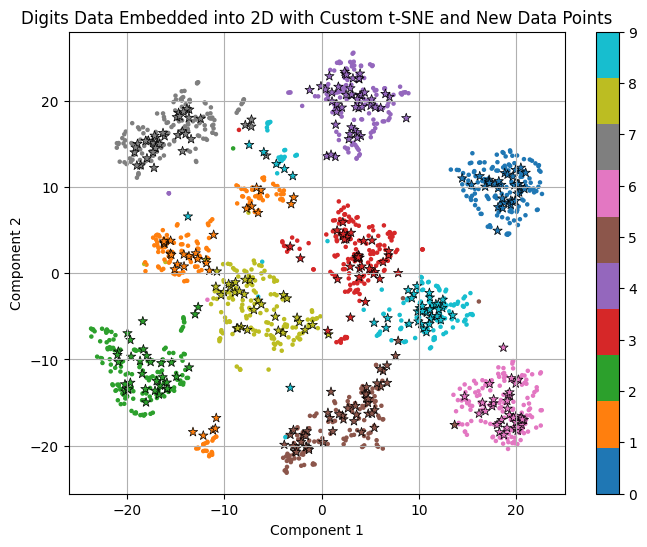

Consistency Score for Mapping New Points: 0.6555


In [10]:
# Transform new data points into the precomputed map
custom_Y_new = custom_tsne.transform(X_train, custom_Y, X_test)

# Visualization of Custom t-SNE results with new points
plt.figure(figsize=(8, 6))
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker='*', s=50, linewidths=0.5, edgecolors='k', c=y_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('Digits Data Embedded into 2D with Custom t-SNE and New Data Points')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

def evaluate_mapping_performance(X_train, X_test, custom_Y, custom_Y_new, k=N//10):
    """
    Evaluate the performance of the t-SNE extension by comparing local neighborhood consistency.
    
    Returns:
        consistency_score (float): Fraction of consistent neighbors between high and low dimensions.
    """
    # High-dimensional neighbors
    nn_high = NearestNeighbors(n_neighbors=k).fit(X_train)
    neighbors_high = nn_high.kneighbors(X_test, return_distance=False)
    
    # Low-dimensional neighbors
    nn_low = NearestNeighbors(n_neighbors=k).fit(custom_Y)
    neighbors_low = nn_low.kneighbors(custom_Y_new, return_distance=False)
    
    # Measure consistency
    matches = 0
    for i in range(len(X_test)):
        matches += len(set(neighbors_high[i]) & set(neighbors_low[i]))
    total_neighbors = len(X_test) * k
    
    consistency_score = matches / total_neighbors
    return consistency_score

# Evaluate the performance of the mapping
consistency_score = evaluate_mapping_performance(X_train, X_test, custom_Y, custom_Y_new, k=N//10)
print(f"Consistency Score for Mapping New Points: {consistency_score:.4f}")



### **t-SNE Extension: Mapping New Samples**

#### **Approach**
The goal was to map new data points into the existing t-SNE embedding without recalculating the entire embedding. For each new data point:
1. **High-Dimensional Similarity**: Compute its similarity to all training points in the high-dimensional space using Gaussian similarity.
2. **Projection to 2D**: Use a weighted average of the training points' low-dimensional positions to place the new points in the t-SNE map.
3. **Validation**: Evaluate the mapping by checking how well the local neighborhoods are preserved between high and low-dimensional spaces using a **consistency score**.

#### **Parameter Selection**
For the neighborhood size \(k\), we initially experimented with values of **50** and **30** .By using **N//10** (10% of the training dataset size) as \(k\) provided the best balance between neighborhood consistency and meaningful visualization.

#### **Results**
- **Visualization**: The stars represent the new points mapped into the t-SNE space. Most points align well with the expected clusters.
- **Consistency Score**: Achieved a score of **0.6555**, meaning ~65% of nearest neighbors are preserved. 

